In [11]:
import matplotlib
import matplotlib.pyplot as plt
get_ipython().magic(u'matplotlib inline')

# Main dependencies
import torch 
import math
import numpy as np
import scipy.io; 
import scipy.fftpack

from timeit import default_timer

/tmp/ipykernel_32/4151440907.py:7: DeprecationWarning: `magic(...)` is deprecated since IPython 0.13 (warning added in 8.1), use run_line_magic(magic_name, parameter_s).
  get_ipython().magic(u'matplotlib inline')


In [12]:
def fftind(size):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.
        
        Input args:
            size (integer): The size of the coordinate array to create
        Returns:
            k_ind, numpy array of shape (2, size, size) with:
                k_ind[0,:,:]:  k_x components
                k_ind[1,:,:]:  k_y components
                
        Example:
        
            print(fftind(5))
            
            [[[ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]
            [ 0  1 -3 -2 -1]]

            [[ 0  0  0  0  0]
            [ 1  1  1  1  1]
            [-3 -3 -3 -3 -3]
            [-2 -2 -2 -2 -2]
            [-1 -1 -1 -1 -1]]]
            
        """
    k_ind = np.mgrid[:size, :size] - int( (size + 1)/2 )
    k_ind = scipy.fftpack.fftshift(k_ind)
    return( k_ind )


def gaussian_random_field(alpha = 3.0,
                          size = 128, 
                          flag_normalize = True):
    """ Returns a numpy array of shifted Fourier coordinates k_x k_y.
        
        Input args:
            alpha (double, default = 3.0): 
                The power of the power-law momentum distribution
            size (integer, default = 128):
                The size of the square output Gaussian Random Fields
            flag_normalize (boolean, default = True):
                Normalizes the Gaussian Field:
                    - to have an average of 0.0
                    - to have a standard deviation of 1.0

        Returns:
            gfield (numpy array of shape (size, size)):
                The random gaussian random field
                
        Example:
        import matplotlib
        import matplotlib.pyplot as plt
        example = gaussian_random_field()
        plt.imshow(example)
        """
        
        # Defines momentum indices
    k_idx = fftind(size)

        # Defines the amplitude as a power law 1/|k|^(alpha/2)
    amplitude = np.power( k_idx[0]**2 + k_idx[1]**2 + 1e-10, -alpha/4.0 )
    amplitude[0,0] = 0
    
        # Draws a complex gaussian random noise with normal
        # (circular) distribution
    noise = np.random.normal(size = (size, size)) \
        + 1j * np.random.normal(size = (size, size))
    
        # To real space
    gfield = np.fft.ifft2(noise * amplitude).real
    
        # Sets the standard deviation to one
    if flag_normalize:
        gfield = gfield - np.mean(gfield)
        gfield = gfield / np.std(gfield)
        
    return gfield

mean:  0.0
std:  1.0



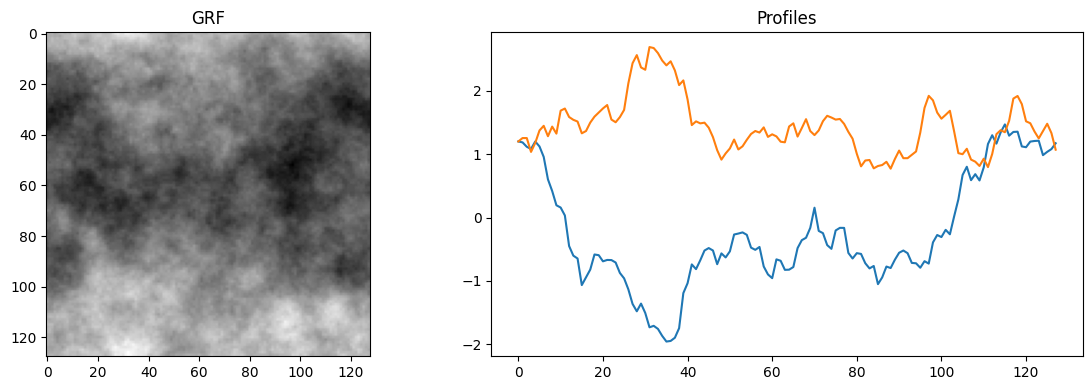

In [27]:
example = gaussian_random_field()
plt.figure(figsize=(12,4))
plt.subplot(121)
plt.imshow(example, cmap='gray')
plt.title("GRF")
print('mean: ', np.mean(example))
print('std: ', np.std(example))
print("")
plt.subplot(122)
plt.plot(example[:,0])
plt.plot(example[0,:])
plt.title('Profiles')
plt.tight_layout()
plt.show()

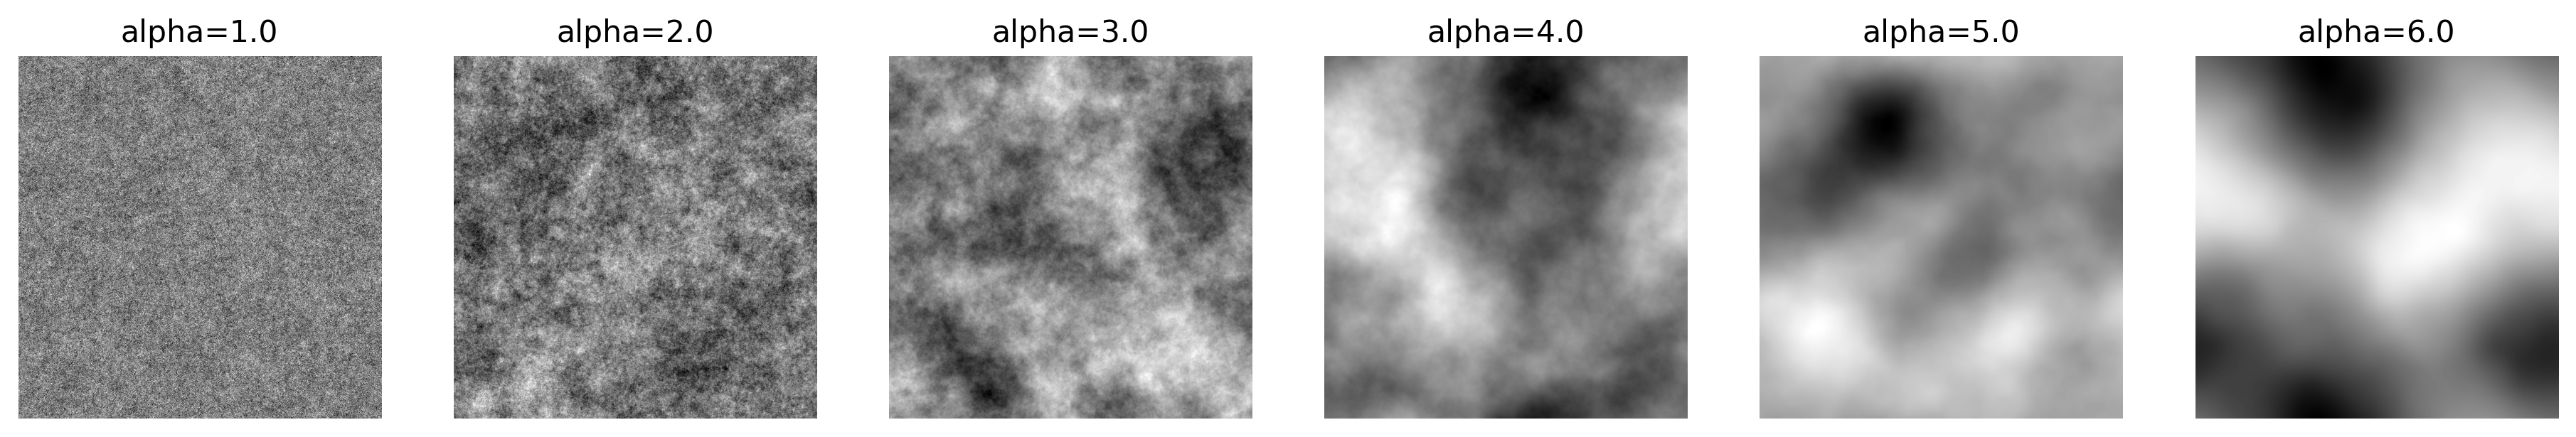

In [47]:
plt.figure(figsize = (18,3), dpi=256)
for idx, alpha in enumerate([1.0, 2.0, 3.0, 4.0, 5.0, 6.0]):
    example = gaussian_random_field(alpha = alpha, size = 512)
    plt.subplot(eval(f"16{idx+1}"))
    plt.axis('off')
    plt.title('alpha='+str(alpha))
    plt.imshow(example, interpolation='none', cmap='gray')

In [55]:
example = gaussian_random_field(alpha = 1, size = 16)
example.shape

(16, 16)

In [19]:
import torch # torch version: 1.12.1+cu113
import math
import scipy.io; # scipy version: 1.10.1

import matplotlib.pyplot as plt

from timeit import default_timer

In [5]:
class GaussianRF(object):

    def __init__(self,
                 dim,
                 size,
                 alpha=2,
                 tau=3,
                 sigma=None,
                 device=None
                ):

        self.dim = dim
        self.device = device

        if sigma is None:
            sigma = tau**(0.5*(2*alpha - self.dim))

        k_max = size//2

        if dim == 1:
            k = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                           torch.arange(start=-k_max, end=0, step=1, device=device)), 0)

            self.sqrt_eig = size*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0] = 0.0

        elif dim == 2:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,1)

            k_x = wavenumers.transpose(0,1)
            k_y = wavenumers

            self.sqrt_eig = (size**2)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0] = 0.0

        elif dim == 3:
            wavenumers = torch.cat((torch.arange(start=0, end=k_max, step=1, device=device), \
                                    torch.arange(start=-k_max, end=0, step=1, device=device)), 0).repeat(size,size,1)

            k_x = wavenumers.transpose(1,2)
            k_y = wavenumers
            k_z = wavenumers.transpose(0,2)

            self.sqrt_eig = (size**3)*math.sqrt(2.0)*sigma*((4*(math.pi**2)*(k_x**2 + k_y**2 + k_z**2) + tau**2)**(-alpha/2.0))
            self.sqrt_eig[0,0,0] = 0.0

        self.size = []
        for j in range(self.dim):
            self.size.append(size)

        self.size = tuple(self.size)

    def sample(self, N):

        coeff = torch.randn(N, *self.size, 2, device=self.device)

        coeff[...,0] = self.sqrt_eig*coeff[...,0]
        coeff[...,1] = self.sqrt_eig*coeff[...,1]

        u = torch.fft.ifft(coeff, dim=self.dim, norm='backward')
        u = u[...,0]

        return u

In [48]:
#w0: initial vorticity
#f: forcing term
#visc: viscosity (1/Re)
#T: final time
#delta_t: internal time-step for solve (descrease if blow-up)
#record_steps: number of in-time snapshots to record
def navier_stokes_2d(w0, f, visc, T, delta_t=1e-4, record_steps=1):

    #Grid size - must be power of 2
    N = w0.size()[-1]

    #Maximum frequency
    k_max = math.floor(N/2.0)

    #Number of steps to final time
    steps = math.ceil(T/delta_t)

    #Initial vorticity to Fourier space
    w_h = torch.fft.fftn(w0, dim=(0, 1), norm="backward")
    #Forcing to Fourier space
    print("f", f.shape)
    f_h = torch.fft.fftn(f, dim=(0, 1), norm="backward")
    print("f_h",f_h.shape)
    #If same forcing for the whole batch
    if len(f_h.size()) < len(w_h.size()):
        f_h = torch.unsqueeze(f_h, 0)

    #Record solution every this number of steps
    record_time = math.floor(steps/record_steps)

    #Wavenumbers in y-direction
    k_y = torch.cat((torch.arange(start=0, end=k_max, step=1, device=w0.device), torch.arange(start=-k_max, end=0, step=1, device=w0.device)), 0).repeat(N,1)
    #Wavenumbers in x-direction
    k_x = k_y.transpose(0,1)
    #Negative Laplacian in Fourier space
    lap = 4*(math.pi**2)*(k_x**2 + k_y**2)
    lap[0,0] = 1.0

    #Dealiasing mask
    dealias = torch.unsqueeze(torch.logical_and(torch.abs(k_y) <= (2.0/3.0)*k_max, torch.abs(k_x) <= (2.0/3.0)*k_max).float(), 0)

    #Saving solution and time
    sol = torch.zeros(*w0.size(), record_steps, device=w0.device)
    sol_t = torch.zeros(record_steps, device=w0.device)
    
    print("sol",sol.shape)
    print("sol_t",sol_t.shape )
    #Record counter
    c = 0
    #Physical time
    t = 0.0
    for j in range(steps):
        #Stream function in Fourier space: solve Poisson equation
        psi_h = w_h.clone()  
        psi_h[0,...] = psi_h[0,...]/lap
        psi_h[1,...] = psi_h[1,...]/lap

        #Velocity field in x-direction = psi_y
        q = psi_h.clone()
        
        temp = q[0,...].clone()
        q[0,...] = -2*math.pi*k_y*q[1,...]
        q[1,...] = 2*math.pi*k_y*temp
        q = torch.fft.ifftn(q, s=(N, N), dim=(0, 1), norm='backward')

        #Velocity field in y-direction = -psi_x
        v = psi_h.clone()
        temp = v[0,...].clone()
        v[0,...] = 2*math.pi*k_x*v[1,...]
        v[1,...] = -2*math.pi*k_x*temp
        v = torch.fft.ifftn(v, s=(N, N), dim=(0, 1), norm='backward')


        #Partial x of vorticity
        w_x = w_h.clone()
        temp = w_x[0,...].clone()
        w_x[0,...] = -2*math.pi*k_x*w_x[1,...]
        w_x[1,...] = 2*math.pi*k_x*temp
        w_x = torch.fft.ifftn(w_x, s=(N, N), dim=(0, 1), norm='backward')


        #Partial y of vorticity
        w_y = w_h.clone()
        temp = w_y[0,...].clone()
        w_y[0,...] = -2*math.pi*k_y*w_y[1,...]
        w_y[1,...] = 2*math.pi*k_y*temp
        w_y = torch.fft.ifftn(w_y, s=(N, N), dim=(0, 1), norm='backward')

        #Non-linear term (u.grad(w)): compute in physical space then back to Fourier space
        F_h = torch.fft.ifftn(q*w_x + v*w_y, s=(N, N), dim=(0, 1), norm='backward')

        #Dealias
        F_h[0,...] = dealias* F_h[0,...]
        F_h[1,...] = dealias* F_h[1,...]

        #Cranck-Nicholson update
        print("F_h", F_h.shape)
        print("f_h", f_h.shape)
        print("lap", lap.shape)
        print("w_h", w_h.shape)
        w_h[0,...] = (-delta_t*F_h[0,...] + delta_t*f_h[0,...] + (1.0 - 0.5*delta_t*visc*lap)*w_h[0,...])/(1.0 + 0.5*delta_t*visc*lap)
        w_h[1,...] = (-delta_t*F_h[1,...] + delta_t*f_h[1,...] + (1.0 - 0.5*delta_t*visc*lap)*w_h[1,...])/(1.0 + 0.5*delta_t*visc*lap)

        #Update real time (used only for recording)
        t += delta_t

        if (j+1) % record_time == 0:
            #Solution in physical space
            w = torch.fft.ifftn(w_h, s=(N, N), dim=(0, 1), norm='backward')

            #Record solution and time
            sol[...,c] = w
            sol_t[c] = t

            c += 1

    return sol, sol_t

In [49]:
device = torch.device('cuda')

#Resolution
s = 256
sub = 1

#Number of solutions to generate
N = 20

#Set up 2d GRF with covariance parameters
GRF = GaussianRF(2, s, alpha=2.5, tau=7, device=device)

#Forcing function: 0.1*(sin(2pi(x+y)) + cos(2pi(x+y)))
t = torch.linspace(0, 1, s+1, device=device)
t = t[0:-1]

X,Y = torch.meshgrid(t, t)
f = 0.1*(torch.sin(2*math.pi*(X + Y)) + torch.cos(2*math.pi*(X + Y)))

#Number of snapshots from solution
record_steps = 200

#Inputs
a = torch.zeros(N, s, s)
#Solutions
u = torch.zeros(N, s, s, record_steps)

#Solve equations in batches (order of magnitude speed-up)

#Batch size
bsize = 20

c = 0
t0 =default_timer()
for j in range(N//bsize):

    #Sample random feilds
    w0 = GRF.sample(bsize)

    #Solve NS
    sol, sol_t = navier_stokes_2d(w0, f, 1e-3, 50.0, 1e-4, record_steps)

    a[c:(c+bsize),...] = w0
    u[c:(c+bsize),...] = sol

    c += bsize
    t1 = default_timer()
    print(j, c, t1-t0)

scipy.io.savemat('ns_data.mat', mdict={'a': a.cpu().numpy(), 'u': u.cpu().numpy(), 't': sol_t.cpu().numpy()})

f torch.Size([256, 256])
f_h torch.Size([256, 256])
sol torch.Size([20, 256, 256, 200])
sol_t torch.Size([200])
F_h torch.Size([256, 256, 256])
f_h torch.Size([1, 256, 256])
lap torch.Size([256, 256])
w_h torch.Size([20, 256, 256])


IndexError: index 1 is out of bounds for dimension 0 with size 1

In [29]:
lap

NameError: name 'lap' is not defined